In [143]:
import pickle
import pandas as pd
import numpy as np
import ast
import torch
import re
from rdkit import Chem
from torch_geometric.data import Data, DataLoader
from torch.utils.data import Dataset, DataLoader

In [144]:
df_all_identified = pd.read_csv('data_RO2/df_ml_ready.csv')

df_all_identified['etl_SMILES'] = df_all_identified['etl_SMILES'].apply(ast.literal_eval)
df_all_identified['htl_SMILES'] = df_all_identified['htl_SMILES'].apply(ast.literal_eval)

df_all_identified.head()

,reduced_formulas,etl,htl,bandgap,device_stack,pce,etl_SMILES,htl_SMILES
0,Ag20Bi20CsI60,"['TiO2-c', 'TiO2-mp']",['P3HT'],1.86,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.53,"[O=[Ti]=O, O=[Ti]=O]",[CCCCCCC1=CSC=C1]
1,Ag20Bi20CsI60,"['TiO2-c', 'TiO2-mp']",['PTB7-th'],1.86,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.53,"[O=[Ti]=O, O=[Ti]=O]",[CCC(=CF)COC1=CC=C(C=C1)C23CCC(CC2)(CC3)C(=O)N...
2,Ag2BiI5,"['TiO2-c', 'TiO2-mp']",['PTAA'],2.22,"['SLG', 'ITO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",2.60,"[O=[Ti]=O, O=[Ti]=O]",[CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C]
3,Ag3BiI6,"['TiO2-c', 'TiO2-mp']",['P3HT'],1.80,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",2.32,"[O=[Ti]=O, O=[Ti]=O]",[CCCCCCC1=CSC=C1]
4,Ag3BiI6,"['TiO2-c', 'TiO2-mp']",['PTAA'],0.00,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",4.30,"[O=[Ti]=O, O=[Ti]=O]",[CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C]


# Label encoding for model comparison
For the comparison of the three final models, the label-encoding of the CTLs would be needed.
Therefore, the label-encoding is already done here, even though it will not be used but for that one model.
If you want to do the label encoding routine, search for the commented out lines throughout the code.

In [145]:
# Get the unique values
etl_values = df_all_identified['etl'].unique()
htl_values = df_all_identified['htl'].unique()

# Create a dictionary mapping each value to an integer
etl_dict = {value: index for index, value in enumerate(etl_values)}
htl_dict = {value: index for index, value in enumerate(htl_values)}

# Replace each value with its corresponding integer
df_all_identified['etl_encoded'] = df_all_identified['etl'].map(etl_dict)
df_all_identified['htl_encoded'] = df_all_identified['htl'].map(htl_dict)

# GNN-specific preparation

## Define required functions

In [146]:
# List of elements to consider
ELEMENTS = ['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'B', 'Li', 'Na',
             'Mg', 'Al', 'Si', 'K', 'Ca', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co',
              'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Rb', 'Sr', 'Y', 'Zr', 
              'Nb', 'Mo', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 
              'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 
              'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 
              'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Th', 'U']

# Function to parse chemical formula for absorber
def parse_formula(formula):
    '''
    Parse a chemical formula and return a dictionary of element counts.
    '''
    element_pattern = r'([A-Z][a-z]?)(\d*)'
    matches = re.findall(element_pattern, formula)
    element_counts = {}
    for (element, count) in matches:
        if element in element_counts:
            element_counts[element] += int(count) if count else 1
        else:
            element_counts[element] = int(count) if count else 1
    return element_counts


# Function to convert formula to feature vector
def formula_to_features(formula):
    '''
    Convert a chemical formula to a feature vector.
    '''
    element_counts = parse_formula(formula)
    features = torch.zeros(len(ELEMENTS), dtype=torch.float)
    for i, element in enumerate(ELEMENTS):
        if element in element_counts:
            features[i] = element_counts[element]
    return features


def smiles_to_graph(smiles):
    if smiles == "no_ctl":
        return None
    mol = Chem.MolFromSmiles(smiles)

# atomic number only    
    
    # Node features: number of each atom in the molecule
    #atom_features = []
    #for atom in mol.GetAtoms():
    #    atom_features.append([atom.GetAtomicNum()])
    #x = torch.tensor(atom_features, dtype=torch.float)

# atomic number and atomic mass     
    
    # atom_features = []
    # for atom in mol.GetAtoms():
    #     atomic_num = atom.GetAtomicNum()
    #     atomic_weight = atom.GetMass()
    #     atom_features.append([atomic_num, atomic_weight])
    # x = torch.tensor(atom_features, dtype=torch.float)
    
# multiple additional features

    def get_atom_features(atom):
        features = [
            atom.GetAtomicNum(),
            atom.GetMass(),
            atom.GetExplicitValence(),
            atom.GetFormalCharge(),
            atom.GetHybridization(),
            atom.GetIsAromatic(),
            atom.GetNumRadicalElectrons(),
            atom.GetTotalValence(),
            atom.IsInRing()
        ]
        return [float(f) if not isinstance(f, bool) else int(f) for f in features]

    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(get_atom_features(atom))
    x = torch.tensor(atom_features, dtype=torch.float)
    
# End of additional features
    
    # Edge indices
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    data = Data(x=x, edge_index=edge_index)
    return data


def prepare_molecular_data(smiles_list):
    '''
    Convert a list of SMILES strings to a list of PyTorch Geometric Data objects.
    '''
    data_list = []
    for smiles in smiles_list:
        data = smiles_to_graph(smiles)
        if data:
            data_list.append(data)
    return data_list


# For multiple graphs
def combine_graphs(graphs):
    '''
    Combine a list of PyTorch Geometric Data objects into a single object.
    '''
    if not graphs:
        return None

    x = torch.cat([g.x for g in graphs], dim=0) # puts the x's together one after the other
    edge_index_list = []
    offset = 0
    for g in graphs:
        edge_index_list.append(g.edge_index + offset)
        offset += g.num_nodes
    edge_index = torch.cat(edge_index_list, dim=1) # puts the edge-indices together

    data = Data(x=x, edge_index=edge_index)
    return data

## Build graph dataset

In [159]:
molecular_data = []


for index, row in df_all_identified.iterrows():
    if index % 1000 == 0:  # Print progress every 10 rows
        print(f"Progress: {index}")

    # Check for empty graph lists
    etl_graphs = prepare_molecular_data(row['etl_SMILES'])
    htl_graphs = prepare_molecular_data(row['htl_SMILES'])

    etl_data = combine_graphs(etl_graphs)
    htl_data = combine_graphs(htl_graphs)

    absorber_features = formula_to_features(row['reduced_formulas'])
    pce = torch.tensor([row['pce']], dtype=torch.float)
    bandgap =  torch.tensor([row['bandgap']], dtype=torch.float)
    # etl_encoded = torch.tensor([row['etl_encoded']], dtype=torch.float) # for CTL label encoding model
    # htl_encoded = torch.tensor([row['htl_encoded']], dtype=torch.float) # for CTL label encoding model

    molecular_data.append({
        'etl': etl_data if etl_graphs else None,  # Assign None if etl_graphs is empty
        'htl': htl_data if htl_graphs else None,  # Assign None if htl_graphs is empty
        'absorber': absorber_features,
        'pce': pce,
        'bandgap': bandgap,
        # 'index': index # this was originally used to ensure shuffling is the same in all models
        # 'etl_encoded': etl_encoded, # for CTL label encoding model
        # 'htl_encoded': htl_encoded  # for CTL label encoding model
    })

Progress: 0
Progress: 1000


[13:12:42] WARNING: not removing hydrogen atom without neighbors


Progress: 2000
Progress: 3000


[13:12:54] WARNING: not removing hydrogen atom without neighbors


Progress: 4000


[13:12:59] WARNING: not removing hydrogen atom without neighbors


Progress: 5000


In [148]:
def ensure_2d(tensor):
    if tensor.dim() < 1:
        tensor = tensor.unsqueeze(0)
    if tensor.dim() < 2:
        tensor = tensor.unsqueeze(0)  # Add a dimension at the beginning
    return tensor

# Define a class for MolecularDataset
class MolecularDataset(Dataset):
    '''
    A PyTorch Dataset class for loading the molecular data.
    '''
    def __init__(self, data):
        self.data = data
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, idx):
        data_point = self.data[idx]
        
        layers = ['etl', 'htl']
        layer_data = {}

        # default_data = {'x': torch.zeros((1,1),  dtype=torch.float), 'edge_index': torch.zeros((2,1), dtype=torch.long)}
        default_data = {'x': torch.zeros((1,9),  dtype=torch.float), 'edge_index': torch.zeros((2,1), dtype=torch.long)} # currently diff
        
        for layer in layers:
            if data_point[layer] is not None:  # Check if layer key exists
                x_data = data_point[layer]['x']
                edge_index_data = data_point[layer]['edge_index']
                
                x_data = ensure_2d(x_data)
                edge_index_data = ensure_2d(edge_index_data)
                if torch.numel(edge_index_data) == 0:
                    edge_index_data = torch.zeros((2,0), dtype=torch.long)
                
                layer_data[layer] = {
                    'x': x_data,
                    'edge_index': edge_index_data,
                }
            else:
                layer_data[layer] = default_data
        
        absorber_features = data_point['absorber']
        pce = data_point['pce']
        bandgap = data_point['bandgap']
        # etl_encoded = data_point['etl_encoded'] # only for label encoding
        # htl_encoded = data_point['htl_encoded'] # only for label encoding

        etl =layer_data['etl']['x']
        htl =layer_data['htl']['x']
        etl_edge_index=layer_data['etl']['edge_index']
        htl_edge_index=layer_data['htl']['edge_index']
                
        return {
            'etl_features':etl,
            'htl_features':htl,
            'etl_edge_indices': etl_edge_index,
            'htl_edge_indices': htl_edge_index,
            'absorber': absorber_features,
            'pce': pce, 
            'bandgap':bandgap,
            # 'etl_encoded': etl_encoded, # for CTL label encoding model
            # 'htl_encoded': htl_encoded,  # for CTL label encoding model
        }

# Train Test Split and Dataloading 

In [161]:
# Train/test/val split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate sizes based on ratios
total_size = len(molecular_data)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# shuffle the data to unbias-the val-test-train-split
rng = np.random.default_rng(seed=42)
rng.shuffle(molecular_data)

# Split the data
train_data = molecular_data[:train_size]
val_data = molecular_data[train_size:train_size + val_size]
test_data = molecular_data[train_size + val_size:]

# Define batch size
batch_size = 1

# Create DataLoader instances
train_loader = DataLoader(MolecularDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(MolecularDataset(val_data), batch_size=batch_size)
test_loader = DataLoader(MolecularDataset(test_data), batch_size=batch_size)

single_data = molecular_data[:2]
# single_data = [molecular_data[0], molecular_data[2]]

single_loader = DataLoader(MolecularDataset(single_data), batch_size=batch_size, shuffle=True)
single_data = molecular_data[:-2]
single_val_loader = DataLoader(MolecularDataset(single_data), batch_size=batch_size)

# Export the random shuffling to use the same test set for CrabNet and XGBoost.

In [174]:
index_list = []
for entry in molecular_data:
    index_list.append(entry['index'])

with open("data_RO2/index_for_train_test_split.pkl", "wb") as f:
    pickle.dump(index_list, f)

# GNN definition

In [39]:
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool, MLP, global_add_pool
from torch_geometric.nn import GCNConv

class MPNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MPNN, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        return x_j

    def update(self, aggr_out):
        return self.lin(aggr_out)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.etl_embedding_dimensions = 32
        self.htl_embedding_dimensions = 32
        # self.absorber_embedding_dimensions = 16
        self.absorber_dimensions = 76
        self.bandgap_dimension = 1
        # arbitrary choice:
        self.hidden_dimension = 32
        self.number_of_regression_layers = 3

        # in_channels are describing the number of node features, atom-type, weight, polarity...
        # self.etl_mpnn = MPNN(in_channels=1, out_channels=self.etl_embedding_dimensions)
        # self.htl_mpnn = MPNN(in_channels=1, out_channels=self.htl_embedding_dimensions)
        self.etl_mpnn = GCNConv(in_channels=9, out_channels=self.etl_embedding_dimensions) # input channels changed to 2 for now
        self.htl_mpnn = GCNConv(in_channels=9, out_channels=self.htl_embedding_dimensions) # input channels changed to 2 for now

        self.fc1 = torch.nn.Linear(self.etl_embedding_dimensions + self.htl_embedding_dimensions + self.absorber_dimensions + self.bandgap_dimension, self.hidden_dimension)
        
        self.regression_layers = torch.nn.ModuleList([self.fc1])
        self.regression_layers.extend([torch.nn.Linear( self.hidden_dimension,  self.hidden_dimension) for i in range(1, self.number_of_regression_layers-1)])
        # 1, because we just want to predict pce:
        self.fc_out = torch.nn.Linear(self.hidden_dimension, 1)
        
        # self.fc_absorber = torch.nn.Linear(self.absorber_dimensions, self.absorber_embedding_dimensions)

    def forward(self, etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorbers, bandgap):
        etl_x = self.etl_mpnn(etl_features, etl_edge_indices) # comment this out for no-graph prediction
        # etl_x = self.etl_mpnn(etl_x, etl_edge_indices)
        etl_x = global_mean_pool(etl_x, torch.zeros(etl_x.size(0), dtype=torch.long)) # comment this out for no-graph prediction
        
        htl_x = self.htl_mpnn(htl_features, htl_edge_indices) # comment this out for no-graph prediction
        # htl_x = self.htl_mpnn(htl_x, htl_edge_indices)
        htl_x = global_mean_pool(htl_x, torch.zeros(htl_x.size(0), dtype=torch.long)) # comment this out for no-graph prediction
        
        # etl_x = torch.zeros([1,self.etl_embedding_dimensions]) # comment this in for no-graph prediction
        # htl_x = torch.zeros([1,self.htl_embedding_dimensions]) # comment this in for no-graph prediction

        # absorbers_embed = self.fc_absorber(absorbers)
        # x = torch.cat([etl_x, htl_x, absorbers_embed], dim=1) 
        
        x = torch.cat([etl_x, htl_x, absorbers, bandgap], dim=1)
        for layer in self.regression_layers: 
            x = F.leaky_relu(layer(x))
        
        x = self.fc_out(x)
        x = F.softplus(x)
        return x


# Model code for 2 MP layer Net (used after GNN_11)

In [85]:
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool, MLP, global_add_pool
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.etl_embedding_dimensions = 32
        self.htl_embedding_dimensions = 32
        self.absorber_dimensions = 76
        self.bandgap_dimension = 1
        self.hidden_dimension = 32
        self.number_of_regression_layers = 3

        # Two GCN layers for ETL processing
        self.etl_mpnn1 = GCNConv(in_channels=9, out_channels=self.etl_embedding_dimensions)
        self.etl_mpnn2 = GCNConv(in_channels=self.etl_embedding_dimensions, out_channels=self.etl_embedding_dimensions)

        # Two GCN layers for HTL processing
        self.htl_mpnn1 = GCNConv(in_channels=9, out_channels=self.htl_embedding_dimensions)
        self.htl_mpnn2 = GCNConv(in_channels=self.htl_embedding_dimensions, out_channels=self.htl_embedding_dimensions)

        self.fc1 = torch.nn.Linear(self.etl_embedding_dimensions + self.htl_embedding_dimensions + self.absorber_dimensions + self.bandgap_dimension, self.hidden_dimension)
        
        self.regression_layers = torch.nn.ModuleList([self.fc1])
        self.regression_layers.extend([torch.nn.Linear(self.hidden_dimension, self.hidden_dimension) for i in range(1, self.number_of_regression_layers-1)])

        self.fc_out = torch.nn.Linear(self.hidden_dimension, 1)

    def forward(self, etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorbers, bandgap):
        # Two-layer processing for ETL
        etl_x = self.etl_mpnn1(etl_features, etl_edge_indices)
        etl_x = F.relu(etl_x)  # Add activation after the first layer
        etl_x = self.etl_mpnn2(etl_x, etl_edge_indices)
        etl_x = global_mean_pool(etl_x, torch.zeros(etl_x.size(0), dtype=torch.long))
    
        # Two-layer processing for HTL
        htl_x = self.htl_mpnn1(htl_features, htl_edge_indices)
        htl_x = F.relu(htl_x)  # Add activation after the first layer
        htl_x = self.htl_mpnn2(htl_x, htl_edge_indices)
        htl_x = global_mean_pool(htl_x, torch.zeros(htl_x.size(0), dtype=torch.long))
    
        x = torch.cat([etl_x, htl_x, absorbers, bandgap], dim=1)
        for layer in self.regression_layers:
            x = F.leaky_relu(layer(x))
    
        x = self.fc_out(x)
        # x = F.softplus(x) # Model performs better without softplus layer
        return x

# Model code for label-encoding model

In [100]:
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool, MLP, global_add_pool
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.etl_embedding_dimensions = 32
        self.htl_embedding_dimensions = 32
        self.absorber_dimensions = 76
        self.bandgap_dimension = 1
        self.etl_label_dimension = 1 # only for label_encoding model
        self.htl_label_dimension = 1 # only for label_encoding model
        self.hidden_dimension = 32
        self.number_of_regression_layers = 3

        # Two GCN layers for ETL processing
        self.etl_mpnn1 = GCNConv(in_channels=9, out_channels=self.etl_embedding_dimensions)
        self.etl_mpnn2 = GCNConv(in_channels=self.etl_embedding_dimensions, out_channels=self.etl_embedding_dimensions)

        # Two GCN layers for HTL processing
        self.htl_mpnn1 = GCNConv(in_channels=9, out_channels=self.htl_embedding_dimensions)
        self.htl_mpnn2 = GCNConv(in_channels=self.htl_embedding_dimensions, out_channels=self.htl_embedding_dimensions)

        self.fc1 = torch.nn.Linear(self.etl_embedding_dimensions + self.htl_embedding_dimensions + self.absorber_dimensions + self.bandgap_dimension + self.etl_label_dimension + self.htl_label_dimension, self.hidden_dimension)
        
        self.regression_layers = torch.nn.ModuleList([self.fc1])
        self.regression_layers.extend([torch.nn.Linear(self.hidden_dimension, self.hidden_dimension) for i in range(1, self.number_of_regression_layers-1)])

        self.fc_out = torch.nn.Linear(self.hidden_dimension, 1)


    # Forward function for label encoding model 
    def forward(self, etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorbers, bandgap, etl_encoded, htl_encoded):        
        etl_x = torch.zeros([1,self.etl_embedding_dimensions]) # comment this in for no-graph prediction
        htl_x = torch.zeros([1,self.htl_embedding_dimensions]) # comment this in for no-graph prediction
        
        x = torch.cat([etl_x, htl_x, absorbers, bandgap, etl_encoded, htl_encoded], dim=1)
        for layer in self.regression_layers: 
            x = F.leaky_relu(layer(x))
        
        x = self.fc_out(x)
        return x

# Model code for absorber only model

In [119]:
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool, MLP, global_add_pool
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.etl_embedding_dimensions = 32
        self.htl_embedding_dimensions = 32
        self.absorber_dimensions = 76
        self.bandgap_dimension = 1
        self.hidden_dimension = 32
        self.number_of_regression_layers = 3

        # Two GCN layers for ETL processing
        self.etl_mpnn1 = GCNConv(in_channels=9, out_channels=self.etl_embedding_dimensions)
        self.etl_mpnn2 = GCNConv(in_channels=self.etl_embedding_dimensions, out_channels=self.etl_embedding_dimensions)

        # Two GCN layers for HTL processing
        self.htl_mpnn1 = GCNConv(in_channels=9, out_channels=self.htl_embedding_dimensions)
        self.htl_mpnn2 = GCNConv(in_channels=self.htl_embedding_dimensions, out_channels=self.htl_embedding_dimensions)

        self.fc1 = torch.nn.Linear(self.etl_embedding_dimensions + self.htl_embedding_dimensions + self.absorber_dimensions + self.bandgap_dimension, self.hidden_dimension)
        
        self.regression_layers = torch.nn.ModuleList([self.fc1])
        self.regression_layers.extend([torch.nn.Linear(self.hidden_dimension, self.hidden_dimension) for i in range(1, self.number_of_regression_layers-1)])

        self.fc_out = torch.nn.Linear(self.hidden_dimension, 1)


    # Forward function for label encoding model 
    def forward(self, etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorbers, bandgap):        
        etl_x = torch.zeros([1,self.etl_embedding_dimensions]) # comment this in for no-graph prediction
        htl_x = torch.zeros([1,self.htl_embedding_dimensions]) # comment this in for no-graph prediction
        
        x = torch.cat([etl_x, htl_x, absorbers, bandgap], dim=1)
        for layer in self.regression_layers: 
            x = F.leaky_relu(layer(x))
        
        x = self.fc_out(x)
        return x

# Training

In [109]:
from torch.utils.tensorboard import SummaryWriter
from torch.optim.swa_utils import AveragedModel#, get_ema_multi_avg_fn

# Initialize the model, optimizer, and loss function
model = Net()

decay = 0.995
#averaged_model = AveragedModel(model, multi_avg_fn=get_ema_multi_avg_fn(decay))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

num_epochs = 1000
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.0001, 
                                                steps_per_epoch=len(train_loader), 
                                                epochs=num_epochs, 
                                                pct_start=0.1,
                                                final_div_factor=1e4)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
#                                                        T_max=50, 
#                                                        eta_min=0, 
#                                                        last_epoch=-1, 
#                                                        verbose='deprecated')

train_writer = SummaryWriter()
val_writer = SummaryWriter()

dataloader = train_loader
val_loader = val_loader

# dataloader = single_loader
# val_loader = single_val_loader

best_validation_loss = np.inf

print("start training...")

# Example training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()

        etl_features = batch['etl_features'].squeeze(0)
        htl_features = batch['htl_features'].squeeze(0)
        etl_edge_indices = batch['etl_edge_indices'].squeeze(0)
        htl_edge_indices = batch['htl_edge_indices'].squeeze(0)
        absorber = batch['absorber']
        bandgap = batch['bandgap']
        # etl_encoded = batch['etl_encoded'] # only for label_encoding model
        # htl_encoded = batch['htl_encoded'] # only for label_encoding model
        
        out = model(etl_features, 
                    htl_features, 
                    etl_edge_indices, 
                    htl_edge_indices, 
                    absorber,
                    bandgap,
                    # etl_encoded, # only for label_encoding model
                    # htl_encoded # only for label_encoding model
                   )
 
        loss = criterion(out, batch['pce'])
        loss.backward()
        optimizer.step()
        #averaged_model.update_parameters(model)
        scheduler.step()
        total_loss += float(loss)
    train_writer.add_scalar('Training Loss', float(loss), epoch)

    model.eval()
    total_val_loss = 0
    for batch in val_loader:        
        etl_features = batch['etl_features'].squeeze(0)
        htl_features = batch['htl_features'].squeeze(0)
        etl_edge_indices = batch['etl_edge_indices'].squeeze(0)
        htl_edge_indices = batch['htl_edge_indices'].squeeze(0)
        absorber = batch['absorber']
        bandgap = batch['bandgap']
        # etl_encoded = batch['etl_encoded'] # only for label_encoding model
        # htl_encoded = batch['htl_encoded'] # only for label_encoding model
        out = model(etl_features, 
                    htl_features, 
                    etl_edge_indices, 
                    htl_edge_indices, 
                    absorber,
                    bandgap,
                    # etl_encoded, # only for label_encoding model
                    # htl_encoded # only for label_encoding model
                   ) 
        loss = criterion(out, batch['pce'])
        total_val_loss += float(loss)
    val_writer.add_scalar('Validation Loss', float(loss), epoch)

    if total_val_loss <= best_validation_loss:
        best_validation_loss = total_val_loss
        torch.save(model.state_dict(), 'models/GNN_12_absorber_only_32.pth')
        #torch.save(averaged_model.state_dict(), 'models/GNN_29_avg_model.pth')
        print(f'(new best)')
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}, Val-Loss: {total_val_loss/len(val_loader)}')


start training...
(new best)
Epoch 1, Loss: 233.53771056115667, Val-Loss: 209.71259878746258
(new best)
Epoch 2, Loss: 185.04073529751977, Val-Loss: 170.2943413979013
(new best)
Epoch 3, Loss: 176.54816320003735, Val-Loss: 161.10710406402382
(new best)
Epoch 4, Loss: 175.08815293748594, Val-Loss: 158.65556909545836
(new best)
Epoch 5, Loss: 173.48446267847422, Val-Loss: 157.25966958454174
(new best)
Epoch 6, Loss: 171.31739657502376, Val-Loss: 156.17577319105612
(new best)
Epoch 7, Loss: 169.6154137709328, Val-Loss: 154.53592303191962
(new best)
Epoch 8, Loss: 167.5090802750294, Val-Loss: 153.4994418182826
(new best)
Epoch 9, Loss: 165.5528997163926, Val-Loss: 153.31697693772313
(new best)
Epoch 10, Loss: 164.22748510599064, Val-Loss: 150.8874346101416
(new best)
Epoch 11, Loss: 162.24106735755822, Val-Loss: 149.5451978576813
(new best)
Epoch 12, Loss: 160.49956948638606, Val-Loss: 147.84836312765566
Epoch 13, Loss: 157.99387671316956, Val-Loss: 148.5917103130824
(new best)
Epoch 14, L

# Evaluation and model comparison

For predictions and loading the models, the model architecture needs to be stated again. 
Adjust the above model according to the following information and then proceed to the plot section.

## Model architectures

In [ ]:
### GNN_1
in 1000 epochs to loss 13.32

In [202]:
########### insert into GNN definition section ####################
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool, MLP, global_add_pool
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.etl_embedding_dimensions = 16
        self.htl_embedding_dimensions = 16
        self.absorber_dimensions = 76
        self.bandgap_dimension = 1
        self.hidden_dimension = 32
        self.number_of_regression_layers = 3

        self.etl_mpnn = GCNConv(in_channels=1, out_channels=self.etl_embedding_dimensions)
        self.htl_mpnn = GCNConv(in_channels=1, out_channels=self.htl_embedding_dimensions)

        self.fc1 = torch.nn.Linear(self.etl_embedding_dimensions + self.htl_embedding_dimensions + self.absorber_dimensions + self.bandgap_dimension, self.hidden_dimension)
        
        self.regression_layers = torch.nn.ModuleList([self.fc1])
        self.regression_layers.extend([torch.nn.Linear(self.hidden_dimension,  self.hidden_dimension) for i in range(1, self.number_of_regression_layers-1)])

        self.fc_out = torch.nn.Linear(self.hidden_dimension, 1)

    def forward(self, etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorbers, bandgap):
        etl_x = self.etl_mpnn(etl_features, etl_edge_indices)
        etl_x = global_mean_pool(etl_x, torch.zeros(etl_x.size(0), dtype=torch.long))
        
        htl_x = self.htl_mpnn(htl_features, htl_edge_indices)
        htl_x = global_mean_pool(htl_x, torch.zeros(htl_x.size(0), dtype=torch.long))
        
        x = torch.cat([etl_x, htl_x, absorbers, bandgap], dim=1)
        for layer in self.regression_layers: 
            x = F.leaky_relu(layer(x))
        
        x = self.fc_out(x)
        #x = F.softplus(x) # possibly no softplus here removes the error
        return x

####### end of insert #############

In [ ]:
######### insert into Training section ##############

decay = 0.995
averaged_model = AveragedModel(model, multi_avg_fn=get_ema_multi_avg_fn(decay))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

num_epochs = 1000
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=num_epochs, pct_start=0.1,final_div_factor=1e2)

######### end of insert ################

In [ ]:
### GNN_2
Everything as in GNN_1, but atom weight was added

In [ ]:
# in smiles_to_graph insert:
    atom_features = []
    for atom in mol.GetAtoms():
        atomic_num = atom.GetAtomicNum()
        atomic_weight = atom.GetMass()
        atom_features.append([atomic_num, atomic_weight])
    x = torch.tensor(atom_features, dtype=torch.float)


In [ ]:
# for the default data in creating MolecularDataset class, change dimensions of the zero verctor:
default_data = {'x': torch.zeros((1,2),  dtype=torch.float), 'edge_index': torch.zeros((2,1), dtype=torch.long)}

In [ ]:
# in the net definitions, change input channels to 2
        self.etl_mpnn = GCNConv(in_channels=2, out_channels=self.etl_embedding_dimensions)
        self.htl_mpnn = GCNConv(in_channels=2, out_channels=self.htl_embedding_dimensions)

In [ ]:
### GNN_3
Mean Squared Error: 14.77943229675293
R^2 Score: 0.5403929552966777
Mean Absolute Error: 2.8730850219726562

In [ ]:
# replace in smiles_to_graph
    def get_atom_features(atom):
        features = [
            atom.GetAtomicNum(),
            atom.GetMass(),
            atom.GetExplicitValence(),
            atom.GetFormalCharge(),
            atom.GetHybridization(),
            atom.GetIsAromatic(),
            atom.GetNumRadicalElectrons(),
            atom.GetTotalValence(),
            atom.IsInRing()
        ]
        return [float(f) if not isinstance(f, bool) else int(f) for f in features]

    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(get_atom_features(atom))
    x = torch.tensor(atom_features, dtype=torch.float)

In [ ]:
# for the default data in creating MolecularDataset class, change dimensions of the zero verctor:
default_data = {'x': torch.zeros((1,9),  dtype=torch.float), 'edge_index': torch.zeros((2,1), dtype=torch.long)}

In [ ]:
# in the net definitions, change input channels to 9
        self.etl_mpnn = GCNConv(in_channels=9, out_channels=self.etl_embedding_dimensions)
        self.htl_mpnn = GCNConv(in_channels=9, out_channels=self.htl_embedding_dimensions)

In [ ]:
## GNN_4
Mean Squared Error: 15.379298210144043
R^2 Score: 0.5217384699304368
Mean Absolute Error: 2.8592941761016846

In [ ]:
# Everything as before, but embedding dimensions 32 instead of 16.
        self.etl_embedding_dimensions = 32
        self.htl_embedding_dimensions = 32

In [ ]:
# and in scheduler final_div_factor: 1e3 (because 1e2 overfits while still jumping losses)

In [ ]:
## GNN_5

Eliminate the graph information by replacing them with zeros. Everything else the same as in GNN_4.

In [ ]:
# Insert this instead of the forward function in the GNN_4 Net().

    def forward(self, etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorbers, bandgap):
        # etl_x = self.etl_mpnn(etl_features, etl_edge_indices) # comment this out for no-graph prediction
        # etl_x = self.etl_mpnn(etl_x, etl_edge_indices)
        # etl_x = global_mean_pool(etl_x, torch.zeros(etl_x.size(0), dtype=torch.long)) # comment this out for no-graph prediction
        
        # htl_x = self.htl_mpnn(htl_features, htl_edge_indices) # comment this out for no-graph prediction
        # htl_x = self.htl_mpnn(htl_x, htl_edge_indices)
        # htl_x = global_mean_pool(htl_x, torch.zeros(htl_x.size(0), dtype=torch.long)) # comment this out for no-graph prediction
        
        etl_x = torch.zeros([1,self.etl_embedding_dimensions]) # comment this in for no-graph prediction
        htl_x = torch.zeros([1,self.htl_embedding_dimensions]) # comment this in for no-graph prediction

        # absorbers_embed = self.fc_absorber(absorbers)
        # x = torch.cat([etl_x, htl_x, absorbers_embed], dim=1) 
        
        x = torch.cat([etl_x, htl_x, absorbers, bandgap], dim=1)
        for layer in self.regression_layers: 
            x = F.leaky_relu(layer(x))
        
        x = self.fc_out(x)
        x = F.softplus(x)
        return x

In [ ]:
## GNN_6
max_lr=0.0001
final_div_factor=1e2

Mean Squared Error: 13.848991394042969
R^2 Score: 0.5693276002514303
Mean Absolute Error: 2.7927744388580322

In [ ]:
## GNN_7
everything as GNN_6 but final_div_factor = 1e3

Mean Squared Error: 13.550704002380371
R^2 Score: 0.5786036347103873
Mean Absolute Error: 2.7916390895843506

In [ ]:
## GNN_8
everything as GNN_6 and GNN_7 but final_div_factor = 1e4
Mean Squared Error: 13.562051773071289
R^2 Score: 0.5782507841432195
Mean Absolute Error: 2.742356300354004

In [ ]:
## GNN_9_test
final_div_factor = 1e4
eliminate PCEs below 2 %
Mean Squared Error: 12.327483177185059
R^2 Score: 0.4462597339252242
Mean Absolute Error: 2.718646764755249

In [ ]:
# GNN_10
no PCEs below 2%
final_div_factor = 1e4
weight_decay=1e-3 (before: 1e-4)

Mean Squared Error: 12.734729766845703
R^2 Score: 0.4279665440353737
Mean Absolute Error: 2.750393867492676

In [ ]:
## GNN_11
everything as GNN_10 but weight decay 1e-5

Mean Squared Error: 12.17917251586914
R^2 Score: 0.45292170065419457
Mean Absolute Error: 2.6727020740509033

In [ ]:
## GNN_12
weight decay back to 1e-4
added an additional layer for htl and etl processing
no softplus layer in the end

Mean Squared Error: 11.764592170715332
R^2 Score: 0.47154431620395776
Mean Absolute Error: 2.6425602436065674

In [129]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool, MLP, global_add_pool
from torch_geometric.nn import GCNConv


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.etl_embedding_dimensions = 32
        self.htl_embedding_dimensions = 32
        self.absorber_dimensions = 76
        self.bandgap_dimension = 1
        self.hidden_dimension = 32
        self.number_of_regression_layers = 3

        # Two GCN layers for ETL processing
        self.etl_mpnn1 = GCNConv(in_channels=9, out_channels=self.etl_embedding_dimensions)
        self.etl_mpnn2 = GCNConv(in_channels=self.etl_embedding_dimensions, out_channels=self.etl_embedding_dimensions)

        # Two GCN layers for HTL processing
        self.htl_mpnn1 = GCNConv(in_channels=9, out_channels=self.htl_embedding_dimensions)
        self.htl_mpnn2 = GCNConv(in_channels=self.htl_embedding_dimensions, out_channels=self.htl_embedding_dimensions)

        self.fc1 = torch.nn.Linear(self.etl_embedding_dimensions + self.htl_embedding_dimensions + self.absorber_dimensions + self.bandgap_dimension, self.hidden_dimension)
    
        self.regression_layers = torch.nn.ModuleList([self.fc1])
        self.regression_layers.extend([torch.nn.Linear(self.hidden_dimension, self.hidden_dimension) for i in range(1, self.number_of_regression_layers-1)])

        self.fc_out = torch.nn.Linear(self.hidden_dimension, 1)

    def forward(self, etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorbers, bandgap):
        # Two-layer processing for ETL
        etl_x = self.etl_mpnn1(etl_features, etl_edge_indices)
        etl_x = F.relu(etl_x)  # Add activation after the first layer
        etl_x = self.etl_mpnn2(etl_x, etl_edge_indices)
        etl_x = global_mean_pool(etl_x, torch.zeros(etl_x.size(0), dtype=torch.long))
    
        # Two-layer processing for HTL
        htl_x = self.htl_mpnn1(htl_features, htl_edge_indices)
        htl_x = F.relu(htl_x)  # Add activation after the first layer
        htl_x = self.htl_mpnn2(htl_x, htl_edge_indices)
        htl_x = global_mean_pool(htl_x, torch.zeros(htl_x.size(0), dtype=torch.long))
    
        x = torch.cat([etl_x, htl_x, absorbers, bandgap], dim=1)
        for layer in self.regression_layers:
            x = F.leaky_relu(layer(x))
    
        x = self.fc_out(x)
        #x = F.softplus(x) # possibly no softplus here removes the error
        return x


In [ ]:
## GNN_13
everything as GNN_12 but with softplus layer in the end

Mean Squared Error: 12.195013999938965
R^2 Score: 0.4522101290976822
Mean Absolute Error: 2.717991352081299

In [ ]:
## GNN_14
everything as GNN_12 but leaky_relu between the two etl and htl layers instead of relu
--> overfits very badly after 400 epochs

Mean Squared Error: 12.911194801330566
R^2 Score: 0.4200398814332983
Mean Absolute Error: 2.805245876312256

In [ ]:
## GNN_15
max_lr=0.001 instead of 0.0001, everything else as GNN_12
Mean Squared Error: 12.947954177856445
R^2 Score: 0.4183886945076104
Mean Absolute Error: 2.810683012008667

Was overwritten by what was supposed to become GNN_16
max_lr back to 0.0001, pct_start = 0.2 instead of 0.1

Mean Squared Error: 12.454482078552246
R^2 Score: 0.4405550240903354
Mean Absolute Error: 2.768221378326416

In [ ]:
## GNN_16
Mean Squared Error: 13.04375171661377
R^2 Score: 0.4140855604161916
Mean Absolute Error: 2.7799715995788574


In [ ]:
## GNN_17
trying to rebuild GNN_16

Mean Squared Error: 12.994876861572266
R^2 Score: 0.4162809750824753
Mean Absolute Error: 2.7726638317108154

This is not GNN_12...

In [ ]:
# GNN_18
final_div_factor back to 1e3 hoping to find the GNN_12 configuration again

Mean Squared Error: 12.174577713012695
R^2 Score: 0.4531281193692762
Mean Absolute Error: 2.6740314960479736

In [ ]:
# GNN_19
lr = 1-e3

Mean Squared Error: 12.212804794311523
R^2 Score: 0.45141097582191614
Mean Absolute Error: 2.671917676925659

In [ ]:
# GNN_20
max_lr = 0.00001

Mean Squared Error: 14.260919570922852
R^2 Score: 0.359411411740551
Mean Absolute Error: 2.969792127609253

In [ ]:
# GNN_21
max_lr = 0.001

Mean Squared Error: 12.907291412353516
R^2 Score: 0.42021520018931935
Mean Absolute Error: 2.872129440307617

In [ ]:
# GNN_22
cycle annealing scheduler with T_max = 100


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

num_epochs = 1000

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=100, 
                                                       eta_min=0, 
                                                       last_epoch=-1, 
                                                       verbose='deprecated')


Mean Squared Error: 12.652148246765137
R^2 Score: 0.43167606946355797
Mean Absolute Error: 2.7812609672546387

In [ ]:
# GNN_23
same as GNN_22 but with lr = 1e-4

Mean Squared Error: 12.442548751831055
R^2 Score: 0.44109108444848644
Mean Absolute Error: 2.750389337539673

In [ ]:
# GNN_24
same as GNN_23 but with t_max = 50

Mean Squared Error: 13.888327598571777
R^2 Score: 0.37614787548216977
Mean Absolute Error: 2.7717573642730713

In [ ]:
# GNN_25
go back to OneCycleR with smaller peak lr


optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

num_epochs = 1000
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.0001, 
                                                steps_per_epoch=len(train_loader), 
                                                epochs=num_epochs, 
                                                pct_start=0.1,
                                                final_div_factor
                                                
Mean Squared Error: 12.103560447692871
R^2 Score: 0.45631812300883134
Mean Absolute Error: 2.6630618572235107

In [ ]:
# GNN_26
as 25, but with also max_lr = 0.00001

Mean Squared Error: 14.209254264831543
R^2 Score: 0.3617321728196772
Mean Absolute Error: 2.95304799079895

In [ ]:
# GNN_27
max_lr back to 0.0001

Number of regression layers = 2

Mean Squared Error: 13.370475769042969
R^2 Score: 0.3994093672942369
Mean Absolute Error: 2.8325576782226562

In [ ]:
# GNN_28
hidden_dimensions = 64 instead of 32


In [ ]:
# COMPARISON MODELS

## GNN_12
# --> load as stated above
Mean Squared Error: 10.126177787780762
R^2 Score: 0.5662597949761423
Mean Absolute Error: 2.5018486976623535

## GNN_12_absorber_only
# set the graphs to zero
    def forward(self, etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorbers, bandgap):        
        etl_x = torch.zeros([1,self.etl_embedding_dimensions]) # comment this in for no-graph prediction
        htl_x = torch.zeros([1,self.htl_embedding_dimensions]) # comment this in for no-graph prediction
        
        x = torch.cat([etl_x, htl_x, absorbers, bandgap], dim=1)
        for layer in self.regression_layers: 
            x = F.leaky_relu(layer(x))
        
        x = self.fc_out(x)
        return x
    
Mean Squared Error: 13.487946510314941
R^2 Score: 0.422263328884837
Mean Absolute Error: 2.925929069519043

## GNN_absorber and label encoded CTLs
# Throughout the entire code, the label_encoded etls and htls need to be included
# the code is commented out but existent in the code here

Mean Squared Error: 14.051036834716797
R^2 Score: 0.39814417023079995
Mean Absolute Error: 2.8378653526306152

# Predictions

Before this section, you need to have reconstructed the Net() definition used in training. Also, the data for the nodes needs to include the correct amount of features.

In [130]:
model = Net()
model.load_state_dict(torch.load('models/GNN_12.pth'))
model.eval()

Net(
  (etl_mpnn1): GCNConv(9, 32)
  (etl_mpnn2): GCNConv(32, 32)
  (htl_mpnn1): GCNConv(9, 32)
  (htl_mpnn2): GCNConv(32, 32)
  (fc1): Linear(in_features=141, out_features=32, bias=True)
  (regression_layers): ModuleList(
    (0): Linear(in_features=141, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc_out): Linear(in_features=32, out_features=1, bias=True)
)

In [131]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
all_predictions = []
all_labels = []

# Evaluate the model
with torch.no_grad():  # Disable gradient calculation for evaluation
    for batch in test_loader:
        etl_features = batch['etl_features'].squeeze(0)
        htl_features = batch['htl_features'].squeeze(0)
        etl_edge_indices = batch['etl_edge_indices'].squeeze(0)
        htl_edge_indices = batch['htl_edge_indices'].squeeze(0)
        absorber = batch['absorber']
        bandgap = batch['bandgap']
        #etl_encoded = batch['etl_encoded'] # label_encoding
        #htl_encoded = batch['htl_encoded'] # label_encoding
        true_labels = batch['pce']
        
        # Forward pass
        predictions = model(etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorber, bandgap)

        # Forward pass for label encoding    
        #predictions = model(etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorber, bandgap, etl_encoded, htl_encoded)
        
        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())

# Compute evaluation metrics (e.g., Mean Squared Error)
mse = mean_squared_error(all_labels, all_predictions)
print(f"Mean Squared Error: {mse}")

# You can also compute other metrics like R^2 score, MAE, etc.
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(all_labels, all_predictions)
mae = mean_absolute_error(all_labels, all_predictions)

print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 10.126177787780762
R^2 Score: 0.5662597949761423
Mean Absolute Error: 2.5018486976623535


## Plots

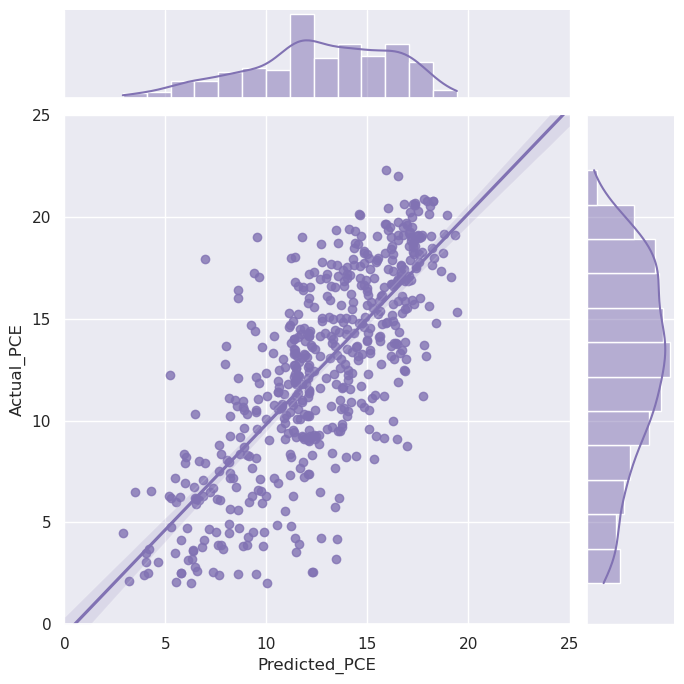

In [127]:
import seaborn as sns
sns.set_theme(style="darkgrid")

pred_flat = [item.item() for sublist in all_predictions for item in sublist]
true_flat = [item.item() for sublist in all_labels for item in sublist]

eval_data = pd.DataFrame({
    'Predicted_PCE': pred_flat,
    'Actual_PCE': true_flat
})

g = sns.jointplot(x="Predicted_PCE", y="Actual_PCE", data=eval_data,
                  kind="reg", truncate=False,
                  xlim=(0, 25), ylim=(0, 25),
                  color="m", height=7)

# Save predictions for ANOVA

In [128]:
# If you want a flat list of floats
all_predictions_save = [x.item() for x in all_predictions]
all_labels_save = [x.item() for x in all_labels]

GNN_predictions = pd.DataFrame()
GNN_predictions['predicted'] = all_predictions_save
GNN_predictions['true_values'] = all_labels_save

# Change name here to reflect which model was saved
GNN_predictions.to_csv('data_RO2/GNN_full_predictions.csv', index=False)